# Regressão logística com regularização

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('data/ex2data2.txt',header=None)

In [94]:
data.head()

,0,1,2
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [95]:
data.describe()

,0,1,2
count,118.000000,118.000000,118.000000
mean,0.054779,0.183102,0.491525
std,0.496654,0.519743,0.502060
min,-0.830070,-0.769740,0.000000
25%,-0.372120,-0.254385,0.000000
50%,-0.006336,0.213455,0.000000
75%,0.478970,0.646563,1.000000
max,1.070900,1.108900,1.000000


## Visualização de dados

Text(0, 0.5, 'Microchip test 2')

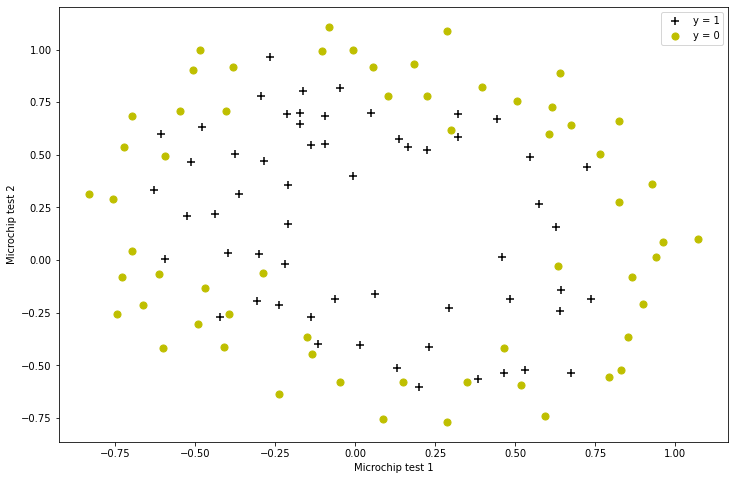

In [80]:
X = np.array(data.iloc[:,:-1])
y = np.array(data.iloc[:,-1])

pos = X[y == 1]
neg = X[y == 0]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(pos[:, :-1], pos[:, -1:], s=50, c='k', marker='+', label='y = 1')
ax.scatter(neg[:, :-1], neg[:, -1:], s=50, c='y', marker='o', label='y = 0')
ax.legend()
ax.set_xlabel('Microchip test 1')
ax.set_ylabel('Microchip test 2')

## Mapeamento de características

In [251]:
def mapFeature(X1, X2, degree=6):
    if X1.ndim > 0:
        out = [np.ones(X1.shape[0])]
    else:
        out = [np.ones(1)]
    for i in range(1, degree + 1):
        for j in range(i + 1):
            out.append((X1 ** (i - j)) * (X2 ** j))

    if X1.ndim > 0:
        return np.stack(out, axis=1)
    else:
        return np.array(out)

X_mf = mapFeature(X[:,0], X[:,1], 6)

## Função de custo e gradiente

In [252]:
def compute_cost(theta, X, y, Lambda):
    m = len(y)
    grad0 = -y @ np.log(sigmoide(X @ theta))
    grad1 = (1 - y) @ np.log(1 - sigmoide(X @ theta))
    return (np.sum(grad0 - grad1) / m) + ((Lambda / (2 * m)) * np.sum(theta ** 2))

theta = np.zeros((X_mf.shape[1], 1))
print(compute_cost(theta, X_mf, y, 1))

0.6931471805599454


In [253]:
import scipy.optimize as opt

def gradient(theta, X, y, Lambda):
    m = len(y)
    grad = (X.T @ (sigmoide(X @ theta) - y)) / m
    grad[1:] = grad[1:] + (Lambda / m) * theta[1:]
    return grad


result = opt.fmin_tnc(func=compute_cost, x0=theta, fprime=gradient, args=(X_mf, y, Lambda))
theta = result[0]
theta

array([ 1.25441477,  0.62276766,  1.19242761, -2.0050551 , -0.87290726,
       -1.36184286,  0.12573867, -0.35536853, -0.35603632, -0.17096334,
       -1.45784686, -0.06683327, -0.61498636, -0.25080292, -1.18096033,
       -0.22566841, -0.20562891, -0.06382329, -0.2718703 , -0.2765899 ,
       -0.46836033, -1.0324736 ,  0.01627585, -0.29695277,  0.00581071,
       -0.32631638, -0.12073389, -0.93022995])

theta:  [ 1.25441477  0.62276766  1.19242761 -2.0050551  -0.87290726 -1.36184286
  0.12573867 -0.35536853 -0.35603632 -0.17096334 -1.45784686 -0.06683327
 -0.61498636 -0.25080292 -1.18096033 -0.22566841 -0.20562891 -0.06382329
 -0.2718703  -0.2765899  -0.46836033 -1.0324736   0.01627585 -0.29695277
  0.00581071 -0.32631638 -0.12073389 -0.93022995]


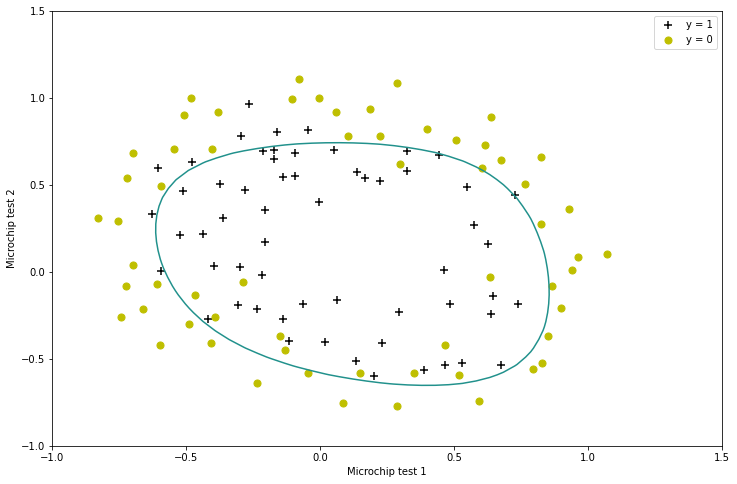

In [255]:
u = np.linspace(-1, 1.5, 50)
v = np.linspace(-1, 1.5, 50)
z = np.zeros((len(u), len(v)))

def mapFeatureForPlotting(X1, X2):
    degree = 6
    out = np.ones(1)
    for i in range(1, degree+1):
        for j in range(i+1):
            out = np.hstack((out, np.multiply(np.power(X1, i-j), np.power(X2, j))))
    return out

for i in range(len(u)):
    for j in range(len(v)):
        z[i,j] = np.dot(mapFeatureForPlotting(u[i], v[j]), theta)
        
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(pos[:, :-1], pos[:, -1:], s=50, c='k', marker='+', label='y = 1')
ax.scatter(neg[:, :-1], neg[:, -1:], s=50, c='y', marker='o', label='y = 0')
ax.contour(u,v,z,0)
ax.legend()
ax.set_xlabel('Microchip test 1')
ax.set_ylabel('Microchip test 2')
print('theta: ', theta)